#### Import packages ...

In [1]:
import sys, time, dill
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
import numpy as np
sys.path.append('../utils/')
from utils import *

#### Set fonts for figures ...

In [2]:
%%capture
# some matplotlib configs to make labels pretty
rcPhysRev(fontsize=10)

#### Define some functions for drawing figure elements ...

In [3]:
def shootingStarGraph(n, kmax, direction='both'):
    if direction=='both':
        G = nx.path_graph(n-kmax+1, create_using=nx.Graph)
        G.add_edges_from([n-kmax,i] for i in range(n-kmax+1, n))
        G = nx.DiGraph(G)
    else:
        G = nx.path_graph(n-kmax+1, create_using=nx.DiGraph)
        if direction=='out':
            G.add_edges_from([0,i] for i in range(n-kmax+1, n))
        elif direction=='in':
            G.add_edges_from([i, n-points-1] for i in range(n-kmax+1, n))
    return G

def edge_degrees(A, degree='total'):    
    # node degrees
    indegs = np.sum(A, axis=0)
    outdegs = np.sum(A, axis=1)
    totdegs = indegs + outdegs
    
    # get matrices of edge degrees
    if degree=='total':
        mat = np.outer(totdegs,totdegs)
    elif degree=='in':
        mat = np.outer(indegs,indegs)
    elif degree=='out':
        mat = np.outer(outdegs,outdegs)
    elif degree=='inout':
        mat = np.outer(indegs,outdegs)
    elif degree=='incount':
        indegs = np.array(indegs, dtype=int)
        outdegs = np.array(outdegs, dtype=int)
        mat = np.repeat(indegs, outdegs)
    elif degree=='outcount':
        indegs = np.array(indegs, dtype=int)
        outdegs = np.array(outdegs, dtype=int)
        mat = np.repeat(outdegs, indegs)  
        
    # list of edge degrees
    if 'count' in degree:
        li = mat
    else:
        li = mat[A>0]

    return li

def drawBox(p0, p1, ax=None, color='#ffe3e3', lw=1, ec='k', **kwargs):
    if ax is None:
        ax = plt.gca()
    d = np.array(p1)-np.array(p0)
    box = mpatches.Rectangle(p0, d[0], d[1], 
        color=color, lw=lw, ec=ec, **kwargs)    
    ax.add_patch(box)
    
def arcLength(t1=0.9, t0=0):
    #c0 = np.sqrt(4*np.pi**2+1)/2 + 1/(2*np.pi*(np.exp(2*np.pi)-np.exp(-2*np.pi)))
    f = lambda t : ((t+1)/2 * np.sqrt(4*np.pi**2*(t+1)+1)
                    + 1/(2*2*np.pi*np.sinh(2*np.pi*(t+1))))
    al = f(t1)-f(t0)
    return al

def positionsOnArc(n, t1=0.9, t0=0):
    #al = arcLength(T)
    p1 = lambda t: -(1+t)*np.cos(2*np.pi*t)
    p2 = lambda t: (1+t)*np.sin(2*np.pi*t)
    ts = np.linspace(0,t1-t0,n)
    points = np.array([[p1(t),p2(t)] for t in ts][::-1]).T
    return points
    
def positionsOnCircle(n, c=(0,0), p0=(0,1)):
    p_from_c = np.array(p0)-np.array(c)
    alpha0 = np.arctan2(p_from_c[1],p_from_c[0])
    r = np.linalg.norm(p_from_c)
    
    alphas = (np.linspace(0,2*np.pi,n+1)+alpha0)[:-1]
    points = np.array([[c[0]+r*np.cos(a), c[1]+r*np.sin(a)] for a in alphas]).T
    return points

def positionsShootingStar(n, kmax, t1=0.9, t0=0):
    n_path = n - kmax + 1
    poa = positionsOnArc(n_path, t1=t1, t0=t0)
    poc = positionsOnCircle(kmax, c=(poa.T)[-1], p0=(poa.T)[-2])
    points = np.concatenate([poa, poc[:,1:]], axis=1)
    return points

from scipy.spatial import distance_matrix
from itertools import permutations

def minimizeLength(A, points):
    point_list = list(points.T)
    orderings = list(permutations(point_list))
    L = np.zeros(len(orderings))
    for i, p in enumerate(orderings):
        L[i] = np.sum(A*distance_matrix(p,p))
    index = np.argmin(L)
    return orderings[index]

def rotation_matrix(angle):
    a = np.pi*angle/180
    rm = np.array([[np.cos(a), -np.sin(a)],
                   [np.sin(a), np.cos(a)]])
    return rm

def increasePlotRange(axes,scale):

    xlim = np.array(axes.get_xlim())
    ylim = np.array(axes.get_ylim())
    x_center = 0.5 * (xlim[0] + xlim[1])
    y_center = 0.5 * (ylim[0] + ylim[1])
    x_halflength = 0.5 * (xlim[1] - xlim[0])
    y_halflength = 0.5 * (ylim[1] - ylim[0])
    
    if isinstance(scale, int):
        scale = [scale, scale, scale, scale]
        
    new_xlim = [x_center-x_halflength*(1+scale[0]), 
                x_center+x_halflength*(1+scale[2])]
    new_ylim = [y_center-y_halflength*(1+scale[1]), 
                y_center+y_halflength*(1+scale[3])]        
    axes.set_xlim(new_xlim)
    axes.set_ylim(new_ylim)

#### Get data for line plot ...
(This can take a while when run the first time.)

In [4]:
# Generate data for line plot
num_trials = 100
nrange = [10, 20, 50]
dirs = ['both'] #, 'in', 'out']
degreeRange = lambda n: range(2,n) # set the values for max degree that we want to consider

load = True
fname = '../data/shooting_star.d'

if load and os.path.exists(fname):
    print('load data')
    sr1 = dill.load(open(fname, 'rb'))
else:
    print('compute data')
    t = time.time()
    sr1 = [[0]*len(degreeRange(n)) for n in nrange]
    for ni, n in enumerate(nrange):
        pointrange = degreeRange(n)
        plist = list(pointrange)
        print(n, plist)
        for ip, points in enumerate(pointrange):
            G = shootingStarGraph(n, points, direction='both')
            A = get_adjacency(G).T
            sr1[ni][ip] = [siminf(A=A) for i in range(num_trials)]
    dill.dump(sr1, open(fname, 'wb'))
    print(time.time()-t)

load data


In [5]:
# Get mean inference accuracy from simulation results sr1
accuracy = [0 for n in nrange]
for ni, n in enumerate(nrange):
    pointrange = degreeRange(n)       
    accuracy[ni] = np.zeros(len(pointrange))
    for ip, points in enumerate(pointrange):
        accuracy[ni][ip] = np.mean([s['accuracy'] for s in sr1[ni][ip]])

#### Get example graphs ...
(Show a selection of inferred shooting-star graphs from which we choose 
four to be included in the figure.)

0


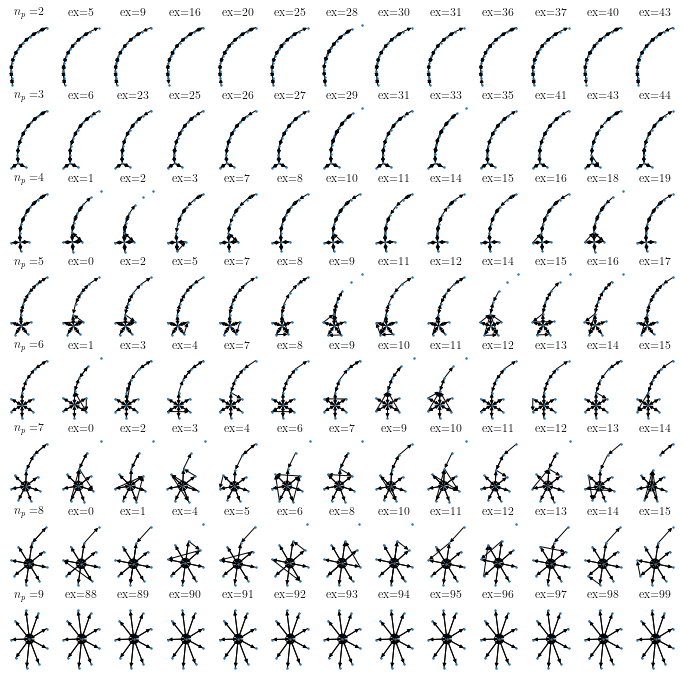

In [6]:
# Get example graphs from sr1
if True:
    n = 10
    ni = np.argwhere(np.array(nrange)==n)[0][0]
    print(ni)
    npoints_max = n
    num_ex = 12
    pointrange = degreeRange(n)

    num_points = len(pointrange)
    fig, axes = plt.subplots(nrows=num_points, ncols=num_ex+1, figsize=(12,12))
    pos = np.zeros((num_points, num_ex)).tolist()

    for ip, p in enumerate(pointrange):
        
        plt.sca(axes[ip][0])
        plt.title(r'$n_p=$'+str(p))
        G = nx.from_numpy_matrix(sr1[ni][ip][0]['adjacency'].T, 
            create_using=nx.DiGraph)
        pos[ip][0] = nx.spring_layout(G)
        pos_tmp = (positionsShootingStar(n, p, t1=0.2).T)
        nx.draw(G, pos_tmp, node_size=2, arrowsize=7, with_labels=False)
            
        example_index = 0
        for ex in range(num_ex):

            # show only examples that include false positives/negatives
            while sr1[0][ip][example_index]['accuracy'] == 1:
                if example_index >= len(sr1[0][ip])-num_ex+ex:
                    break
                else:
                    example_index += 1

            plt.sca(axes[ip][ex+1])
            plt.title('ex='+str(example_index))
            nx.draw(nx.from_numpy_matrix(sr1[0][ip][example_index]['inferred_network'].T, 
                create_using=nx.DiGraph), pos_tmp, node_size=2, 
                arrowsize=7, with_labels=False)
            example_index +=1
    #dill.dump(pos, open('shootingstar_position_dict.d','wb'))
    plt.savefig('../figures/shootingstar_inference_examples.pdf')

#### Draw Figure ...
(This is the figure in the appendix of our paper.)

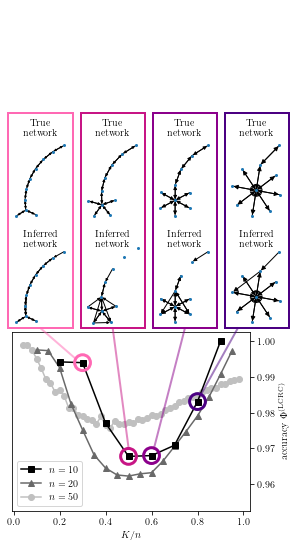

In [8]:
fig = plt.figure(constrained_layout=True, figsize=(4,7.5))

# create axes
heights1 = np.array([0.20, 0.175, 0.175, 0.37])
heights2 = np.array([0.20, 0.195, 0.195, 0.33])
spec44 = gridspec.GridSpec(ncols=4, nrows=4, height_ratios=heights1, figure=fig)
spec41 = gridspec.GridSpec(ncols=1, nrows=4, height_ratios=heights2, figure=fig)
spec11 = gridspec.GridSpec(ncols=1, nrows=1, #bottom=0.7, right=0.5, 
                           figure=fig)
axes = {}
axes['00'] = fig.add_subplot(spec41[0,0])
axes['30'] = fig.add_subplot(spec41[3,0])
axes['w'] = fig.add_subplot(spec11[0,0])
axes['w'].set_facecolor("None")
axes['w'].set_xlim([0,1])
axes['w'].set_ylim([0,1])
axes['w'].axis('off')

for i in range(4):
    axes['1'+str(i)] = fig.add_subplot(spec44[1, i])
    axes['2'+str(i)] = fig.add_subplot(spec44[2, i])  

# set colors
color3 = ['#000000', 'dimgrey', 'silver'] #['#022957','#ff8000','#6e6e6e']
pinks = ['indigo', 'darkmagenta', 'mediumvioletred', #'deeppink', 
         'hotpink'][::-1]# , 'lightpink']

# draw example networks
kmaxes = np.array([3,5,6,8])
example_ids = [6, 14, 16, 11] #might need to update this
net_list = [(k-2, example_ids[i]) for i,k in enumerate(kmaxes)]
arrowsizes = [4,5,7,9]
for i in range(4):
    plt.sca(axes['1'+str(i)])
    sim = sr1[0][net_list[i][0]][net_list[i][1]]
    positions = positionsShootingStar(10, kmaxes[i], t1=0.2).T 
    G = nx.from_numpy_matrix(sim['adjacency'].T, 
        create_using=nx.DiGraph)
    nx.draw(G, positions, node_size=4, arrowsize=arrowsizes[i], with_labels=False)
    increasePlotRange(axes['1'+str(i)],[0.15, 0, 0.15, 0.3])
    
    plt.sca(axes['2'+str(i)])
    G2 = nx.from_numpy_matrix(sim['inferred_network'].T, 
        create_using=nx.DiGraph)
    nx.draw(G2, positions, node_size=4, arrowsize=arrowsizes[i], with_labels=False)
    increasePlotRange(axes['2'+str(i)], [0.15, 0.1, 0.15, 0.2])
    
# make line plot
for ni, n in enumerate(nrange):
    pointrange = degreeRange(n)
    axes['30'].plot(np.array(pointrange)/n, accuracy[ni], 
             marker=['s','^','o'][ni], color=color3[ni], 
             label=r'$n='+str(n)+'$', zorder=10-ni)
    axes['30'].set_ylabel(r'accuracy $\Phi$\textsuperscript{(LCRC)}')
    axes['30'].set_xlabel(r'$K/n$')
axes['30'].legend()

# draw pink boxes
if True:
    boxlow = []
    dx = 0.263
    y0 = 0.363+0.035
    dy = 0.373+0.03
    for i in range(4):
        x0 = 0.005+i*1.18/4
        drawBox((x0,y0), (x0+dx,y0+dy), ax=axes['w'], 
            color='None', lw=2, ec=pinks[i], clip_on=False)
        if i < 3:
            boxlow += [x0+dx/2]
        else:
            boxlow += [x0+dx/5]

# draw pink circles
n = 10
pointrange = degreeRange(n)
for i, ip in enumerate(kmaxes-degreeRange(n)[0]):
    x = [(np.array(pointrange)/n)[ip]]
    y = [accuracy[0][ip]]
    axes['30'].scatter(x, y, 250, marker='o',
        linewidth=3, facecolors='none', edgecolors=pinks[i], zorder=20)
axes['30'].set_ylim([0.9525, 1.0025])    
axes['30'].yaxis.tick_right()
axes['30'].yaxis.set_label_position('right')

if True:
    axes['w'].set_xlim([0,1])
    axes['w'].set_ylim([0,1])

# add text in pink boxes
for i in range(4):
    axes['1'+str(i)].text(0.5,0.97, 'True\n network', fontsize=10,
                    ha='center', va='center', 
                    transform=axes['1'+str(i)].transAxes) #, rotation=90)
    axes['2'+str(i)].text(0.5,0.97, 'Inferred\n network', fontsize=10,
                    ha='center', va='center', 
                    transform=axes['2'+str(i)].transAxes) #, rotation=90)
  
fig.canvas.draw_idle()

# add lines to pink boxes
for i, ip in enumerate(kmaxes-degreeRange(n)[0]):
    x = [((np.array(pointrange)-0.3)/n)[ip]]
    y = [accuracy[0][ip]]    
    display_coordinates = axes['30'].transData.transform((x[0],y[0]))
    ax_coordinates = (axes['w'].transAxes.inverted()).transform(display_coordinates)
    line = np.array([[ax_coordinates[0], boxlow[i]], [ax_coordinates[1], y0]])
    pointer = line[:,1]-line[:,0]
    normed_pointer = pointer / np.linalg.norm(pointer)
    line[:,0] += normed_pointer*[0.05, 0.02, 0.02, 0.03][i]
    axes['w'].plot(line[0], line[1], '-', lw=2, alpha=0.5,
            color=pinks[i], clip_on=False, zorder=20)

# draw schematic
if False:
    plt.sca(axes['00'])
    G0 = shootingStarGraph(10,5)
    positions = positionsShootingStar(10,5,t1=0.2).T
    # transpose positions
    positions = -positions[:,::-1]
    # rotate positions
    c = np.array([-0.5, 0.75])
    alpha=-20
    for i in range(len(positions)):
        vec = positions[i]-c
        rotated_vec = np.dot(rotation_matrix(alpha), vec)
        positions[i] = rotated_vec + c
    nx.draw(G0, pos=positions)
    plt.scatter([-0.5, -0.5], [0.75,1.5], color=['red','white'])
else:
    axes['00'].axis('off')

plt.savefig('../figures/figure_shootingstar.pdf')   